In [7]:
import os
import matplotlib.pyplot as plt
import torch
import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

In [3]:
dir(gp)

['__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'absolute_import',
 'division',
 'kernels',
 'likelihoods',
 'models',
 'print_function',
 'util']

## Definition of Gaussian Process

$ f \sim \mathcal{GP}\left(0, \mathbf{K}_f(x, x')\right) $ 

## Mapping of the output space

$ y = f(x) + \epsilon,\quad \epsilon \sim \mathcal{N}\left(0, \beta^{-1}\mathbf{I}\right). $

where *y* is a point in the output space
ϵ = Gaussian observation noise

## Kernel Function (for covariance matrix)

$ k(x,x') = \sigma^2 \exp\left(-\frac{\|x-x'\|^2}{2l^2}\right). $
where: 
- σ = variance of the amplitude (squared)
- *l* = lengthscale

In [8]:
pyro.enable_validation(True)       # can help with debugging
pyro.set_rng_seed(0)

# Input Data

$ y = 0.5\sin(3x) + \epsilon, \quad \epsilon \sim \mathcal{N}(0, 0.2). $

In [46]:
N = 20
X = dist.Uniform(0.0, 5.0).sample(sample_shape=(N,))
y = 0.5 * torch.sin(3*X) + dist.Normal(0.0, 0.2).sample(sample_shape=(N,))

In [47]:
X

tensor([ 4.5028,  0.2674,  0.7939,  2.0960,  0.8764,  4.2360,  0.6100,
         1.2802,  0.0848,  1.0806,  4.5562,  4.5469,  4.2896,  4.4303,
         4.7230,  1.8598,  3.6000,  4.7273,  3.3270,  4.9992])

In [48]:
y

tensor([ 0.6572,  0.5465,  0.4535, -0.3050,  0.5810, -0.1342,  0.3682,
        -0.6083, -0.0074,  0.1534, -0.0022,  0.5271,  0.5899,  0.6884,
         0.6315, -0.1249, -0.5318,  0.4505, -0.3402,  0.5523])

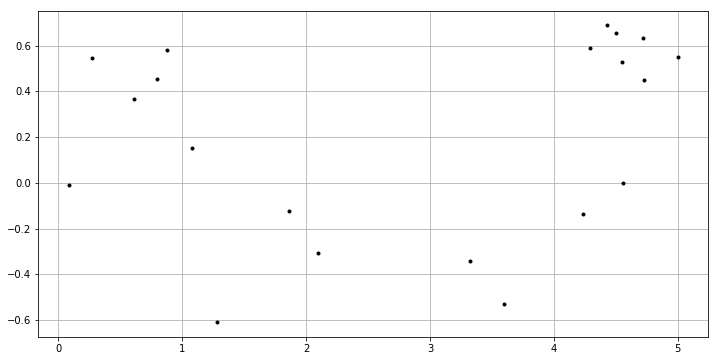

In [49]:
plt.figure(figsize=(12, 6))
plt.grid(axis = 'both')
plt.plot(X.numpy(),y.numpy(), 'k.')

## Defining the model from RBF kernel

In [85]:
kernel_rbf = gp.kernels.RBF(input_dim=1,
                        variance=torch.tensor(5.),
                        lengthscale = torch.tensor(10.))
gp_regression = gp.models.GPRegression(X, y, kernel_rbf, 
                                       noise=torch.tensor(0.1))

In [86]:
n_prior_samples = 2
n_test = 500
Xtest = torch.linspace(-0.5, 5.5, n_test)

In [87]:
noise = gp_regression.noise
noise

Parameter containing:
tensor(0.1000)

In [88]:
cov = kernel_rbf.forward(Xtest) + noise.expand(n_test).diag()
cov

tensor([[ 5.1000,  5.0000,  5.0000,  ...,  4.1824,  4.1794,  4.1764],
        [ 5.0000,  5.1000,  5.0000,  ...,  4.1854,  4.1824,  4.1794],
        [ 5.0000,  5.0000,  5.1000,  ...,  4.1884,  4.1854,  4.1824],
        ...,
        [ 4.1824,  4.1854,  4.1884,  ...,  5.1000,  5.0000,  5.0000],
        [ 4.1794,  4.1824,  4.1854,  ...,  5.0000,  5.1000,  5.0000],
        [ 4.1764,  4.1794,  4.1824,  ...,  5.0000,  5.0000,  5.1000]])

In [97]:
samples = dist.MultivariateNormal(torch.zeros(n_test), covariance_matrix=cov)\
                      .sample(sample_shape=(n_prior_samples,))

In [96]:
print(len(samples), samples.shape)

2 torch.Size([2, 500])


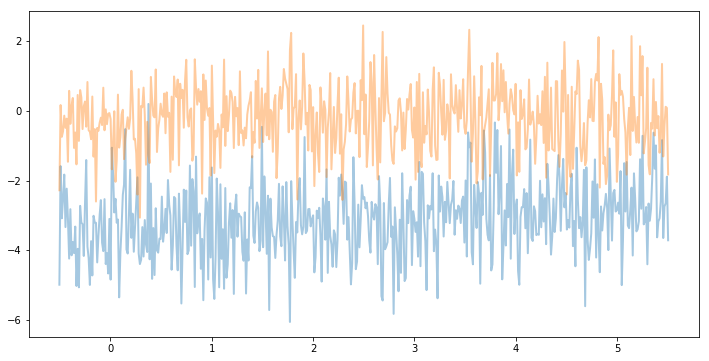

In [84]:
plt.figure(figsize=(12, 6))
plt.plot(Xtest.numpy(), samples.numpy().T, lw=2, alpha=0.4)

## Learning Kernel Parameters from Data
- Kernel Parameters are set by hand (initially) 
- Here we will use SVI to learn those parameters (sigma, l)

In [100]:
optim = Adam({"lr": 0.005})
svi = SVI(gp_regression.model, 
          gp_regression.guide, 
          optim, 
          loss=Trace_ELBO())

In [101]:
losses = []
num_steps = 2500
for i in range(num_steps):
    losses.append(svi.step())

In [102]:
losses

[16.410045623779297,
 16.369810104370117,
 16.329853057861328,
 16.29038429260254,
 16.251392364501953,
 16.212646484375,
 16.174596786499023,
 16.136985778808594,
 16.099720001220703,
 16.062864303588867,
 16.026561737060547,
 15.990707397460938,
 15.955291748046875,
 15.920400619506836,
 15.885885238647461,
 15.851812362670898,
 15.818214416503906,
 15.785089492797852,
 15.752510070800781,
 15.720237731933594,
 15.688581466674805,
 15.657262802124023,
 15.626398086547852,
 15.595956802368164,
 15.565887451171875,
 15.53635025024414,
 15.507144927978516,
 15.47854995727539,
 15.450311660766602,
 15.422428131103516,
 15.394876480102539,
 15.367856979370117,
 15.341270446777344,
 15.31491470336914,
 15.289022445678711,
 15.2635498046875,
 15.238424301147461,
 15.213651657104492,
 15.189172744750977,
 15.16510009765625,
 15.141324996948242,
 15.117881774902344,
 15.094827651977539,
 15.072006225585938,
 15.049558639526367,
 15.027410507202148,
 15.005528450012207,
 14.983929634094238,
 1

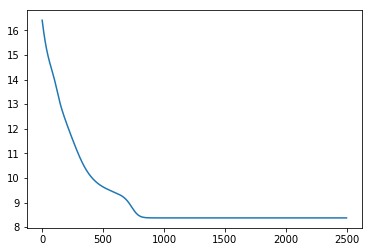

In [103]:
plt.plot(losses)

In [118]:
mean, cov = gp_regression(Xtest, full_cov=True, noiseless=False)

In [123]:
mean.detach().numpy()

array([-0.02454756, -0.02411432, -0.02358617, -0.02295821, -0.02222541,
       -0.02138282, -0.02042544, -0.01934825, -0.0181464 , -0.01681488,
       -0.01534898, -0.01374387, -0.01199492, -0.0100976 , -0.00804747,
       -0.00584029, -0.00347193, -0.00093852,  0.00176373,  0.00463825,
        0.00768837,  0.0109171 ,  0.01432716,  0.01792105,  0.0217009 ,
        0.02566852,  0.02982547,  0.03417289,  0.03871158,  0.0434419 ,
        0.04836379,  0.05347701,  0.05878058,  0.06427328,  0.06995339,
        0.07581878,  0.08186679,  0.08809429,  0.09449764,  0.1010728 ,
        0.10781507,  0.1147195 ,  0.12178042,  0.12899165,  0.13634664,
        0.1438382 ,  0.15145871,  0.15919998,  0.16705339,  0.17500967,
        0.18305923,  0.19119194,  0.19939713,  0.20766363,  0.21598001,
        0.22433415,  0.23271357,  0.24110557,  0.24949674,  0.25787354,
        0.26622185,  0.27452752,  0.2827758 ,  0.2909517 ,  0.29904008,
        0.3070255 ,  0.31489214,  0.3226245 ,  0.33020636,  0.33

In [114]:
sd = cov.diag().sqrt()
print(sd.shape)
sd

torch.Size([500])


tensor([ 0.4277,  0.4265,  0.4252,  0.4239,  0.4225,  0.4210,  0.4195,
         0.4180,  0.4163,  0.4146,  0.4129,  0.4111,  0.4092,  0.4073,
         0.4054,  0.4033,  0.4013,  0.3991,  0.3970,  0.3948,  0.3925,
         0.3903,  0.3880,  0.3856,  0.3833,  0.3809,  0.3785,  0.3761,
         0.3737,  0.3713,  0.3689,  0.3666,  0.3642,  0.3619,  0.3596,
         0.3573,  0.3551,  0.3530,  0.3509,  0.3488,  0.3468,  0.3449,
         0.3430,  0.3412,  0.3395,  0.3379,  0.3363,  0.3349,  0.3335,
         0.3322,  0.3310,  0.3299,  0.3289,  0.3279,  0.3270,  0.3262,
         0.3255,  0.3249,  0.3243,  0.3238,  0.3234,  0.3230,  0.3227,
         0.3224,  0.3221,  0.3219,  0.3217,  0.3216,  0.3215,  0.3214,
         0.3213,  0.3212,  0.3211,  0.3210,  0.3209,  0.3208,  0.3207,
         0.3206,  0.3204,  0.3203,  0.3201,  0.3199,  0.3197,  0.3195,
         0.3192,  0.3189,  0.3186,  0.3183,  0.3180,  0.3176,  0.3173,
         0.3169,  0.3165,  0.3161,  0.3157,  0.3153,  0.3149,  0.3145,
      

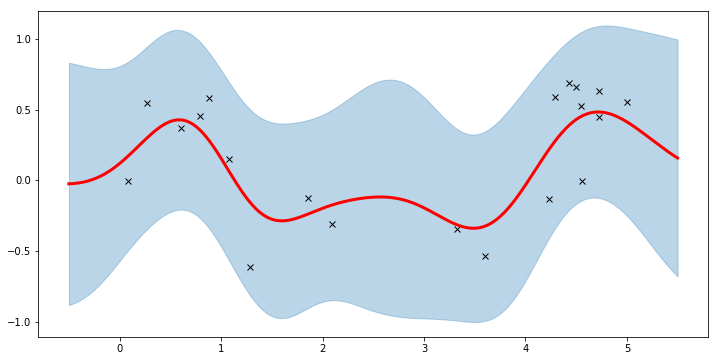

In [134]:
plt.figure(figsize=(12, 6))
## Plot Observed Points
plt.plot(X.numpy(), y.numpy(), 'kx')
## Plot Mean
plt.plot(Xtest.numpy(), mean.detach().numpy(), 'r', lw=3)
## Plot Variance
plt.fill_between(Xtest.numpy(),  # plot the two-sigma uncertainty about the mean
                         (mean - 2.0 * sd).detach().numpy(),
                         (mean + 2.0 * sd).detach().numpy(),
                         color='C0', alpha=0.3)

## Chaning Kernel - 1

In [145]:
kernel_brownie = gp.kernels.Brownian(input_dim=1,
                        variance=torch.tensor(1.))
gp_regression = gp.models.GPRegression(X, y, kernel_brownie, 
                                       noise=torch.tensor(0.1))

In [146]:
optim = Adam({"lr": 0.005})
svi = SVI(gp_regression.model, 
          gp_regression.guide, 
          optim, 
          loss=Trace_ELBO())
losses = []
num_steps = 2500
for i in range(num_steps):
    losses.append(svi.step())

In [147]:
losses

[9.74875259399414,
 9.748870849609375,
 9.74875259399414,
 9.748769760131836,
 9.748819351196289,
 9.748800277709961,
 9.748758316040039,
 9.748750686645508,
 9.748762130737305,
 9.748781204223633,
 9.748781204223633,
 9.748767852783203,
 9.748748779296875,
 9.748750686645508,
 9.748758316040039,
 9.74876594543457,
 9.748760223388672,
 9.748756408691406,
 9.748746871948242,
 9.74874496459961,
 9.748754501342773,
 9.748754501342773,
 9.748758316040039,
 9.748750686645508,
 9.748750686645508,
 9.748743057250977,
 9.748746871948242,
 9.748748779296875,
 9.74875259399414,
 9.74875259399414,
 9.748746871948242,
 9.748750686645508,
 9.74875259399414,
 9.748750686645508,
 9.74875259399414,
 9.748746871948242,
 9.74875259399414,
 9.748746871948242,
 9.748750686645508,
 9.748746871948242,
 9.748746871948242,
 9.74874496459961,
 9.748748779296875,
 9.748748779296875,
 9.74874496459961,
 9.748748779296875,
 9.748750686645508,
 9.748750686645508,
 9.748746871948242,
 9.748743057250977,
 9.74875068

In [148]:
mean, cov = gp_regression(Xtest, full_cov=True, noiseless=False)

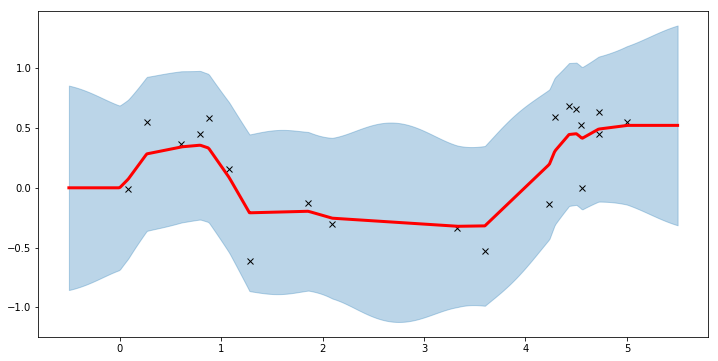

In [149]:
plt.figure(figsize=(12, 6))
## Plot Observed Points
plt.plot(X.numpy(), y.numpy(), 'kx')
## Plot Mean
plt.plot(Xtest.numpy(), mean.detach().numpy(), 'r', lw=3)
## Plot Variance
plt.fill_between(Xtest.numpy(),  # plot the two-sigma uncertainty about the mean
                         (mean - 2.0 * sd).detach().numpy(),
                         (mean + 2.0 * sd).detach().numpy(),
                         color='C0', alpha=0.3)

## Chaning Kernel - 2

In [166]:
kernel_3 = gp.kernels.Cosine(input_dim=1,
                        variance=torch.tensor(5.),
                        lengthscale = torch.tensor(10.))
gp_regression = gp.models.GPRegression(X, y, kernel_rbf, 
                                       noise=torch.tensor(0.1))

In [167]:
n_prior_samples = 2
n_test = 500
Xtest = torch.linspace(-0.5, 5.5, n_test)
noise = gp_regression.noise
optim = Adam({"lr": 0.005})
svi = SVI(gp_regression.model, 
          gp_regression.guide, 
          optim, 
          loss=Trace_ELBO())
losses = []
num_steps = 2500
for i in range(num_steps):
    losses.append(svi.step())

In [168]:
losses

[10.296977043151855,
 10.27292537689209,
 10.24911117553711,
 10.225544929504395,
 10.20221996307373,
 10.179141998291016,
 10.156327247619629,
 10.133777618408203,
 10.111480712890625,
 10.089463233947754,
 10.067712783813477,
 10.046236038208008,
 10.02503490447998,
 10.004111289978027,
 9.983453750610352,
 9.963075637817383,
 9.94296646118164,
 9.923124313354492,
 9.903554916381836,
 9.884244918823242,
 9.865180969238281,
 9.84637451171875,
 9.827803611755371,
 9.809476852416992,
 9.791380882263184,
 9.77349853515625,
 9.755833625793457,
 9.738373756408691,
 9.721108436584473,
 9.70403003692627,
 9.687132835388184,
 9.670417785644531,
 9.653861045837402,
 9.637475967407227,
 9.621245384216309,
 9.605167388916016,
 9.589244842529297,
 9.573468208312988,
 9.557825088500977,
 9.54233455657959,
 9.526985168457031,
 9.511775016784668,
 9.496703147888184,
 9.481770515441895,
 9.466970443725586,
 9.452327728271484,
 9.4378080368042,
 9.423434257507324,
 9.409202575683594,
 9.39511013031005

In [169]:
mean, cov = gp_regression(Xtest, full_cov=True, noiseless=False)

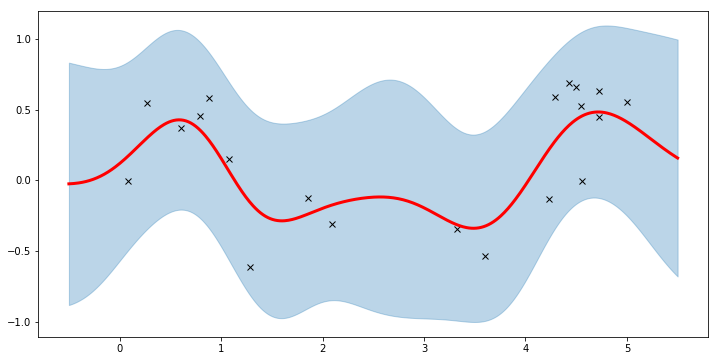

In [170]:
plt.figure(figsize=(12, 6))
## Plot Observed Points
plt.plot(X.numpy(), y.numpy(), 'kx')
## Plot Mean
plt.plot(Xtest.numpy(), mean.detach().numpy(), 'r', lw=3)
## Plot Variance
plt.fill_between(Xtest.numpy(),  # plot the two-sigma uncertainty about the mean
                         (mean - 2.0 * sd).detach().numpy(),
                         (mean + 2.0 * sd).detach().numpy(),
                         color='C0', alpha=0.3)